1. Install Dependencies and Setup 

In [1]:
!pip install tensorflow opencv-python matplotlib


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
appnope                      0.1.4
asttokens                    2.4.1
astunparse                   1.6.3
certifi                      2024.8.30
charset-normalizer           3.3.2
comm                         0.2.2
contourpy                    1.3.0
cycler                       0.12.1
debugpy                      1.8.5
decorator                    5.1.1
executing                    2.0.1
flatbuffers                  24.3.25
fonttools                    4.53.1
gast                         0.6.0
google-pasta                 0.2.0
grpcio                       1.66.1
h5py                         3.11.0
idna                         3.8
ipykernel                    6.29.5
ipython                      8.27.0
jedi                         0.19.1
jupyter_client               8.6.2
jupyter_core                 5.7.2
keras                        3.5.0
kiwisolver                   1.4.5
l

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

2. Remove Dodgy Images

In [6]:
import cv2
import imghdr

/var/folders/l5/c3z0kn795lg2hbsfkk9s8s9c0000gn/T/ipykernel_29467/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir):   
    image_class_path = os.path.join(data_dir, image_class)
    
    if not os.path.isdir(image_class_path):
        continue
        
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 136 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
# Class 0 - Happy People
# Class 1 - Sad People 
batch = data_iterator.next()

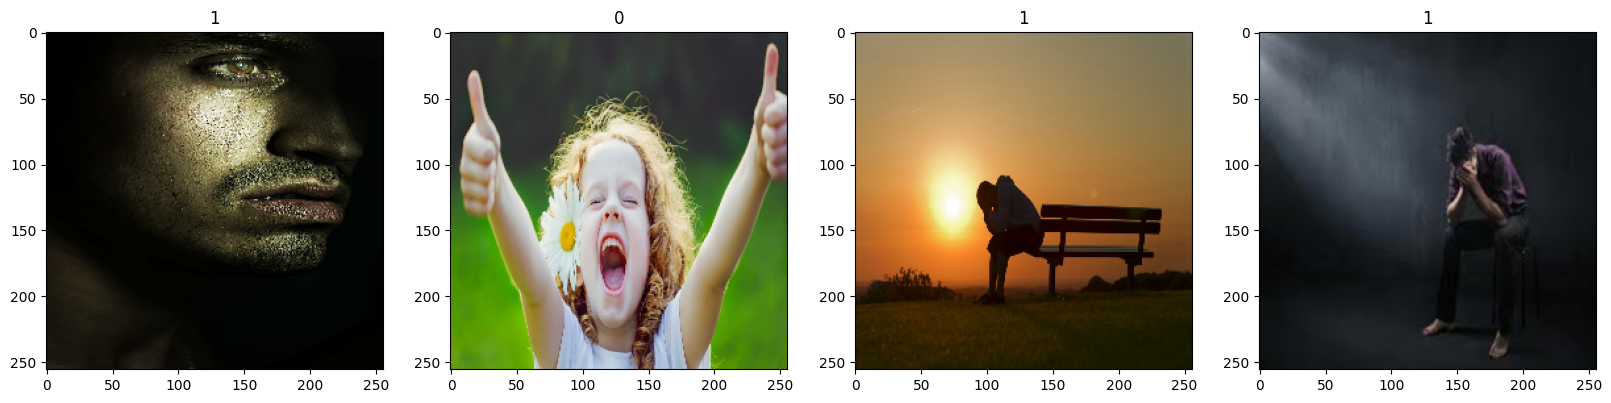

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [3.32124606e-02, 3.32124606e-02, 3.32124606e-02],
          [1.39368877e-01, 1.39368877e-01, 1.39368877e-01],
          ...,
          [9.42885410e-03, 9.42885410e-03, 9.42885410e-03],
          [3.55698541e-02, 3.55698541e-02, 3.55698541e-02],
          [3.55590805e-02, 3.55590805e-02, 3.55590805e-02]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [5.77000044e-02, 5.77000044e-02, 5.77000044e-02],
          [1.24654613e-01, 1.24654613e-01, 1.24654613e-01],
          ...,
          [4.08313237e-03, 4.08313237e-03, 4.08313237e-03],
          [2.43566185e-02, 2.43566185e-02, 2.43566185e-02],
          [3.52941193e-02, 3.52941193e-02, 3.52941193e-02]],
 
         [[1.53186280e-04, 1.53186280e-04, 1.53186280e-04],
          [7.79189169e-02, 7.79189169e-02, 7.79189169e-02],
          [7.77879879e-02, 7.77879879e-02, 7.77879879e-02],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.0000

5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

3

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

6. Build Deep Learning Model

In [20]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/Users/atwins/Documents/GitHub/image-classification/imageclassification/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - accuracy: 0.4727 - loss: 1.4604 - val_accuracy: 0.6875 - val_loss: 0.9935
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 468ms/step - accuracy: 0.5534 - loss: 1.1854 - val_accuracy: 0.7812 - val_loss: 0.5961
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 520ms/step - accuracy: 0.6367 - loss: 0.7266 - val_accuracy: 0.5938 - val_loss: 0.6913
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step - accuracy: 0.6719 - loss: 0.6600 - val_accuracy: 0.6250 - val_loss: 0.6519
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step - accuracy: 0.7031 - loss: 0.6018 - val_accuracy: 0.7188 - val_loss: 0.5264
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step - accuracy: 0.7474 - loss: 0.5411 - val_accuracy: 0.8125 - val_loss: 0.4953
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step - accuracy: 0.7852 - loss: 0.4936 - val_accuracy: 0.7812 - val_loss: 0.5277
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 466ms/step - accuracy: 0.8268 - loss: 0.4794 - val_accuracy: 0.7812 - val_loss:

8. Plot Performance

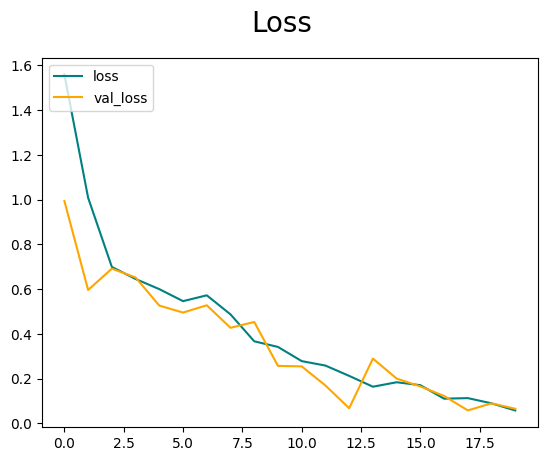

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

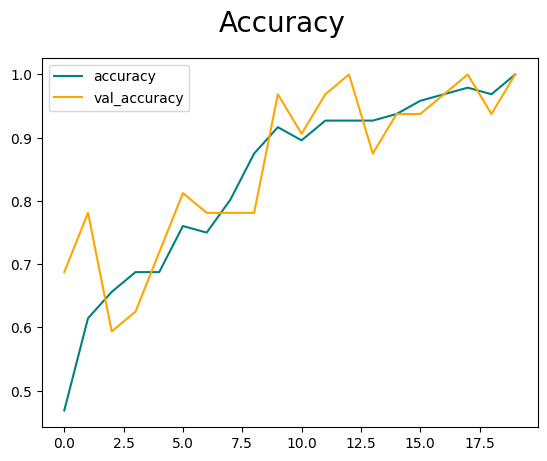

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
len(test)

0

In [34]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2024-08-31 15:31:03.327793: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [35]:
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

Precision: 0.0
Recall: 0.0
Accuracy: 0.0


10. Test

In [36]:
import cv2

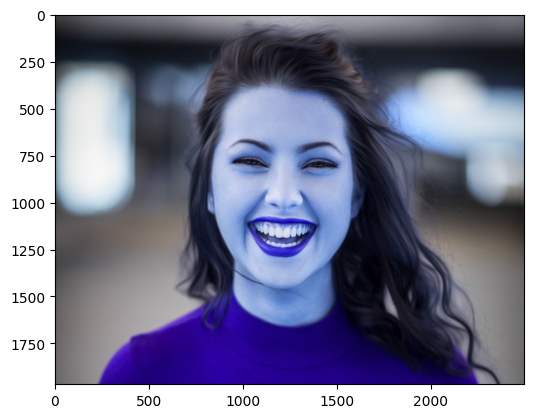

In [37]:
img = cv2.imread('happytest.jpg')
plt.imshow(img)
plt.show()

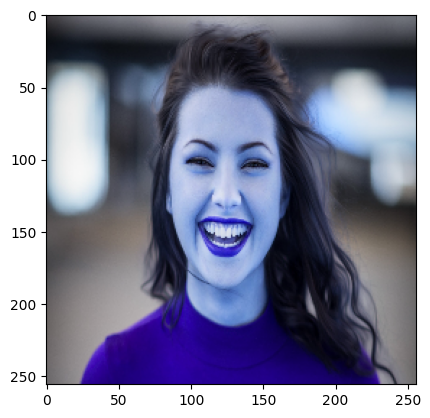

In [38]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [39]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [40]:
yhat

array([[0.9472137]], dtype=float32)

In [41]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


11. Save the Model

In [42]:
from tensorflow.keras.models import load_model

In [43]:
model_path = os.path.join('models', 'imageclassifier.keras')

In [44]:
new_model = load_model(model_path)

In [45]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[0.9858924]], dtype=float32)